In [1]:
from jax import grad
import pickle
import jax.numpy as jnp
from IPython.core.display import HTML
#this css file can be downloaded from [David's repo](https://github.com/ketch/PseudoSpectralPython/blob/master/custom.css)
#Then set the address of css file as per your address of file
#Following two commands are not needed for calculations.
css_file = '/Users/rajvanmp/Downloads/custom.css'

#HTML(open(css_file, "r").read())

In [2]:
from scipy import integrate
import sympy as sp
import numpy as np
import sys
from numpy import linalg as la 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128


HTML(open(css_file, "r").read())
font = {'size'   : 15}
matplotlib.rc('font', **font)
#from RKSchemes import ImEx_schemes

fft = np.fft.fft
ifft = np.fft.ifft

from IPython.display import HTML
css_file = '/Users/rajvanmp/Downloads/custom.css'

In [3]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

In [4]:
def test(x,n="real"):
    if n=="real":
        return jnp.real(jnp.exp(1j*x))
    else:
        return jnp.imag(jnp.exp(1j*x))
dx_test = grad(test)

(32768, 2) complex128 31.414967797905504 64
(512, 2)


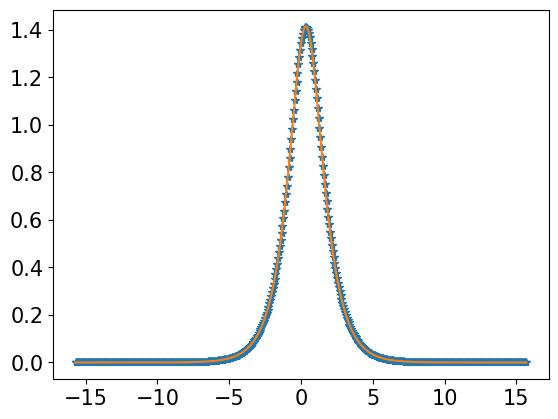

In [5]:
file_name="Petviashvili_ini.pkl"
m = 512
with open(file_name, 'rb') as f:
        fdict = pickle.load(f)
v = fdict["v"]
p = fdict["p"]
x = fdict["x"]
xi = fdict["xi"]
L = x[-1]-x[0]
kppa = fdict["kppa"]
mu = fdict["mu"]
sol_real = np.stack([v,p],axis=-1)
sol  = np.exp(1j*mu*0.0)*sol_real
skip = int(sol.shape[0]/m)
sol_g = sol[::skip,:]
x_g = x[::skip]
print(sol.shape,sol.dtype,L,skip)
print(sol_g.shape)
plt.plot(x_g,sol_g[:,0].real,"*")
plt.plot(x,sol[:,0].real)
#plt.plot(np.imag(sol))

In [6]:




fft = np.fft.fft
ifft = np.fft.ifft


In [5]:
ini_type = "2 solitons"
if ini_type == "petviashvili":
    %run ini_conditions/petviashvili.py
    print("Yo")
elif ini_type == "cubic":
    %run ini_conditions/cubic.py
elif ini_type == "2 solitons":
    %run ini_conditions/solitons.py 2
elif ini_type == "3 solitons":
    %run ini_conditions/solitons.py 3

No of solitons in ini. cond. is 2
2 soliton selected
<class 'numpy.ndarray'> complex128


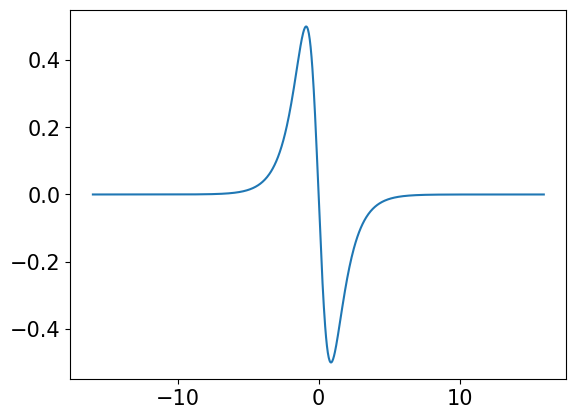

In [9]:
plt.plot(x,dx_sol.real)

<class 'numpy.ndarray'> complex128


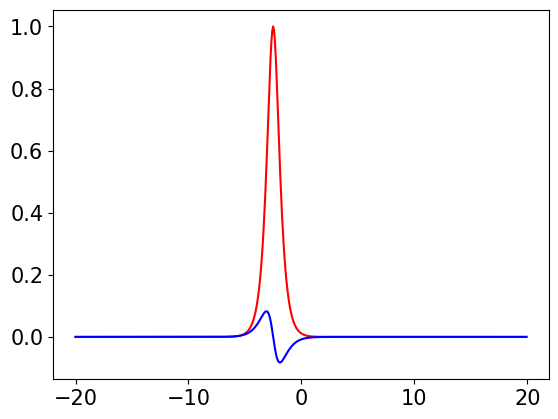

In [8]:
#Choose ImEx scheme

def choose_imex(imex_scheme="default"):
    from Biswas_Ketcheson_TimeIntegrators import ImEx_schemes

    if imex_scheme=="default":
        print("Choosin default ImEx")
        A_ex    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
        A_im = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
        b_ex = np.array([24/55.,1./5,4./11])
        b_im = b_ex     
        C=None
        imex_stages=3
    if imex_scheme=="a":
        #3rd order ImEx with b This method is taken from Implicit-explicit 
        # Runge-Kutta methods for time-dependent partial differential equations by Ascher, Steven Ruuth and Spiteri.
        print("Using 3rd order ImEx with b  This method is taken from Implicit-explicit Runge-Kutta methods for time-dependent partial differential equations by Ascher, Steven Ruuth and Spiteri.")

        A_im,A_ex,C,b_im,b_oth = ImEx_schemes(4,3,2,2)
        b_ex = b_im
        imex_stages=4

    if imex_scheme=="b":
        #3rd order ImEx with b. This method is taken from Additive Runge–Kutta schemes 
        #for convection–diffusion–reaction equations by Kennedy and Carpenter.
        print("Using 3rd order ImEx with b . This method is taken from Additive Runge–Kutta schemes for convection–diffusion–reaction equations by Kennedy and Carpenter.")
        A_im,A_ex,C,b_im,b_oth = ImEx_schemes(4,3,2,3)
        b_ex = b_im
        imex_stages=4
    if imex_scheme=="c":
        #4th order ImEx with b and 3rd order ImEx with bhat. This method is taken from Additive Runge–Kutta schemes 
        #for convection–diffusion–reaction equations by Kennedy and Carpenter.
        print("4th order ImEx with b. This method is taken from Additive Runge–Kutta scheme for convection–diffusion–reaction equations by Kennedy and Carpenter.")
        A_im,A_ex,C,b_im,b_oth = ImEx_schemes(6,4,3,4)
        b_ex = b_im
        imex_stages=6

    return A_im,A_ex,C,b_im,b_ex,imex_stages



1024 (1024, 2)


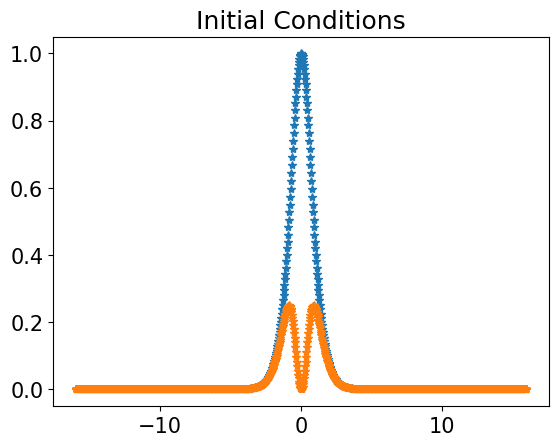

In [12]:


#u0 = np.zeros(2*m)

q0_ini  = sol
q1_ini  = dx_sol
vh = np.real(q0_ini)
wh = np.imag(q0_ini)

ph = np.real(q0_ini)
qh = np.imag(q0_ini)

u_ini = np.stack((q0_ini,q1_ini),axis=1)



plt.title("Initial Conditions")
plt.plot(x,np.square(np.abs(u_ini[:,0])),"*")
plt.plot(x,np.square(np.abs(u_ini[:,1])),"*")
print(len(xi),u_ini.shape)

In [13]:
kppa

8

In [10]:
def rhs_linear(uft,u,xi,tau,kppa):
    #Evaluate the linear term
    m = len(xi)
    #rho = u[:m]; q = u[m:];
    q0 = u[:,0]
    q1 = u[:,1]
    v = np.zeros_like(u)
    q0hat = uft[:,0]
    q1hat = uft[:,1]
    q0_x = ifft(1j*xi*q0hat)
   #q0_xx = ifft(-xi*xi*q0hat)
    q1_x = ifft(1j*xi*q1hat)
    rhs_q0 = 1j*q1_x
    rhs_q1 = 1j*(-q0_x+q1)/tau
    v[:,0] = rhs_q0; v[:,1] = rhs_q1
    return v

def dxi_u(uft,u,xi,i):
    q0hat = uft[:,0]
    q1hat = uft[:,1]

    v = np.zeros_like(u)

    dxi_q0 = ifft(np.power(1j*xi,i)*q0hat)
    dxi_q1 = ifft(np.power(1j*xi,i)*q1hat)

    v[:,0] = dxi_q0; v[:,1] = dxi_q1

    return v


In [11]:
def rhs_nonlinear(u,uft, xi,tau,kppa):
    #Evaluate the nonlinear term
    m = len(xi)
    q0 = u[:,0]; q1 = u[:,1]
    v = np.zeros_like(u)
    q0_rhs = 1j*kppa*np.square(np.abs(q0))*q0
    q1_rhs = np.zeros_like(q0_rhs)
    
    v[:,0] = q0_rhs; v[:,1] = q1_rhs
    return v

In [12]:
def I1(u,xi,kppa,tau):
   
    q0 = u[:,0]
    q1 = u[:,1]

    q0sqr = np.square(np.abs(q0))
    q1sqr = np.square(np.abs(q1))

    return -0.5*np.sum(q0sqr+tau*q1sqr)

def I2(u,xi,kppa,tau):
    uft = np.zeros_like(u)
    uft[:,0] = np.fft.fft(u[:,0])
    uft[:,1] = np.fft.fft(u[:,1])
    q0 = u[:,0]
    q1 = u[:,1]

    v = np.real(q0)
    w = np.imag(q0)

    p = np.real(q1)
    q = np.imag(q1)

    u_x = dxi_u(uft,u,xi,1.0)

    v_x = np.real(u_x[:,0])
    w_x = np.imag(u_x[:,0])

    p_x = np.real(u_x[:,1])
    q_x = np.imag(u_x[:,1])

    return 0.5*np.sum(v*w_x-w*v_x+tau*(p*q_x-q*p_x))

def H(u,xi,kppa,tau):
    uft = np.zeros_like(u)
    uft[:,0] = np.fft.fft(u[:,0])
    uft[:,1] = np.fft.fft(u[:,1])
    q0 = u[:,0]
    q1 = u[:,1]

    v = np.real(q0)
    w = np.imag(q0)

    p = np.real(q1)
    q = np.imag(q1)

    u_x = dxi_u(uft,u,xi,1.0)

    v_x = np.real(u_x[:,0])
    w_x = np.imag(u_x[:,0])

    p_x = np.real(u_x[:,1])
    q_x = np.imag(u_x[:,1])

    return np.sum(v_x*p+w_x*q - 0.5*( np.square(p) + np.square(q) ) - 0.25*kppa*np.square( np.square(v) + np.square(w) ))




In [13]:
sys.path.append('/Users/rajvanmp/station_X/pyGP_fields')

In [14]:
from GPE import GPE_scalar_field
from GPE import ImEx
from GPE import GPE_scalar_field_1d2c

In [15]:


def setup_tau(imx,dt,xi,tau):
    lmda_list=[]
    for s in range(imx.s):
        impf = imx.im_A[s][s]
        print(s,imx.s)
        omega = xi*dt*impf
        bta = -xi*dt*impf/tau
        chk = np.ones_like(xi)
    
        l = [[[chk[i],omega[i]],[bta[i],(chk[i]-1j*dt*impf/tau)]] for i in range(len(xi))]
    #l = [[[1.0+impf*dt*1j*np.square(xi[i]),0.0 ],[bta[i],(chk[i]-1j*dt)/tau]] for i in range(len(xi))]

        mt = np.array(l)
        lmdamat = np.linalg.inv(mt)

        lmda_list.append(lmdamat)
    print(mt.shape, mt.dtype,lmdamat.shape,q0_ini.shape,q1_ini.shape,u_ini.shape)

    return lmda_list

def run_nls_hyper_example(dt,x,xi,kppa,T,tau,lmda_list,imx,inv_list):
    
    
    tmax = T

    

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    #print(nplt,"nmax",nmax)
    
   
    mass_ini = np.sum(np.square(np.abs(q0_ini)))

    frames = [u_ini,]
   
    tt = [0,]
    err_l = []
    mass_l = []
    mass_err_l=[]
    
    rhoq = GPE_scalar_field_1d2c(m,2,rhs_linear,rhs_nonlinear,imx,u_ini)

    inv_ini = [f(u_ini,xi,kppa,tau) for f in inv_list]
    print("Ini invariant", inv_ini)
    
    
    for n in range(0,nmax):
        
        #print(n)
        for k in range(imx.s):
            rhoq.update_stage_sum(k,dt)
            
            rhoq.do_fft(k,lmda_list[k],dt)
            
            rhoq.update_K(k,xi,tau,kppa)
           
            
            
            
        rhoq.sum_contributions(dt)
        
        
        
        t = (n+1)*dt
        

        
        
        if np.mod(n,nplt) == 0:
            frames.append(rhoq.psi)
            
            tt.append(t)
            
            #err = sol_err(psi.psi,t,nx,T,max_err)
           # err_l.append(err)
            
           # mass = psi_1.calc_mass()+psi_2.calc_mass()
           # mass_err = (mass-mass_ini)/mass_ini
            
          ##  mass_l.append(mass)
           # mass_err_l.append(mass_err)
            
            print("time ",t/tmax,t)
            
    u = rhoq.psi
    sol = exact_soln_np(t*np.ones_like(x),x,kppa)
    q0_diff = u[:,0]-sol
    q0_err_abs_max = np.max(np.abs(q0_diff))
    q0_err_max_real = np.max(np.real(q0_diff))
    q0_err_msq_real = np.mean(np.square(np.real(q0_diff)))
    q0_err_max_imag = np.max(np.imag(q0_diff))
    q0_err_msq_imag = np.mean(np.square(np.imag(q0_diff)))
    errs = [q0_err_abs_max,q0_err_max_real,q0_err_msq_real,q0_err_max_imag,q0_err_msq_imag]
    inv_fin = [f(u,xi,kppa,tau) for f in inv_list]

    inv_change = [np.abs((ini-fin)/(ini+1e-12) )for ini,fin in zip(inv_ini,inv_fin)]
    #err =  sol_err(psi.psi,t,nx,T,max_err)
    #err_l.append(err)
            
   # mass = psi_1.calc_mass()+psi_2.calc_mass()
    #mass_err = (mass-mass_ini)/mass_ini
            
   # mass_l.append(mass)
   # mass_err_l.append(mass_err)
       
    return frames,tt,inv_change,inv_fin,errs
 





In [16]:
ini_type

'2_soliton'

In [17]:
#########       Setup and Run Numerical Experiment

dt=0.0001       ## Choose dt


# Choose ImEx Scheme, options are None,a,b,c
imex_sch = "a"
A_im,A_ex,C,b_im,b_ex,imex_stages = choose_imex(imex_sch)  

# Initialize imex table for simulation
imx = ImEx(imex_stages,A_im,A_ex,b_im,b_ex)


# List of tau values for which u wanna run simulation
tau_list = [0.001,0.01,0.1]
inv_list = [H,I1,I2]
frame_dict_list = []
t_list = []

for tau in tau_list:
    lmda_list = setup_tau(imx,dt,xi,tau)
    frm,tt,inv_change,inv_fin,errs = run_nls_hyper_example(dt,x,xi,kppa,T,tau,lmda_list,imx,inv_list)
    frame_dict_list.append({"tau":tau,"scheme":imex_sch,"frame_list":frm,"t_list":tt,"inv_change":inv_change,"inv_final":inv_fin,"errors":errs})
    


import pickle
case=ini_type+"_imex_"+imex_sch+"_"
file_name = case+"_tau.pkl"
# Save lists of dicts containing lists of frames & corresponding times for each tau in a file
with open(file_name, 'wb') as f:
    pickle.dump(frame_dict_list,f)

#ldecp = [[[chk[i],-omega[i]],[-bta[i],chk[i]*1j/tau]] for i in range(len(xi))]
#f = np.array([[rho0[i],q0[i]] for i in range(len(x))])
#dtl = -bta+omega
    
#lmdamat = [[-(bta/dtl), omega/dtl],[-(1.0/dtl), 1.0/dtl]]

Using 3rd order ImEx with b  This method is taken from Implicit-explicit Runge-Kutta methods for time-dependent partial differential equations by Ascher, Steven Ruuth and Spiteri.
0 4
1 4
2 4
3 4
(1024, 2, 2) complex128 (1024, 2, 2) (1024,) (1024,) (1024, 2)
class shapes (1024, 2) (4, 1024, 2)
my shape (1024, 2) psi shape (1024, 2)
Ini invariant [-74.6666666666675, -32.010666666665855, -5.897715398408653e-17]
time  2e-05 0.0001
time  0.020020000000000003 0.10010000000000001
time  0.04002 0.2001
time  0.060020000000000004 0.30010000000000003
time  0.08002000000000001 0.4001
time  0.10002 0.5001
time  0.12002000000000002 0.6001000000000001
time  0.14002 0.7001000000000001
time  0.16002 0.8001
time  0.18002 0.9001
time  0.20002 1.0001
time  0.22002000000000002 1.1001
time  0.24002000000000004 1.2001000000000002
time  0.26002000000000003 1.3001
time  0.28002000000000005 1.4001000000000001
time  0.30002 1.5001
time  0.32002 1.6001
time  0.34002000000000004 1.7001000000000002
time  0.36002 1

In [18]:
import pickle
#file_name = "cubic_imex_a__tau.pkl"
#file_name = "3_soliton_imex_a__tau.pkl"
#with open(file_name, 'rb') as f:
#    frame_dict_list = pickle.load(f)



In [19]:
print(len(frame_dict_list))


3


2.9706579206058556e-06
4.220070635798031e-08
1.7287742665977125e-09


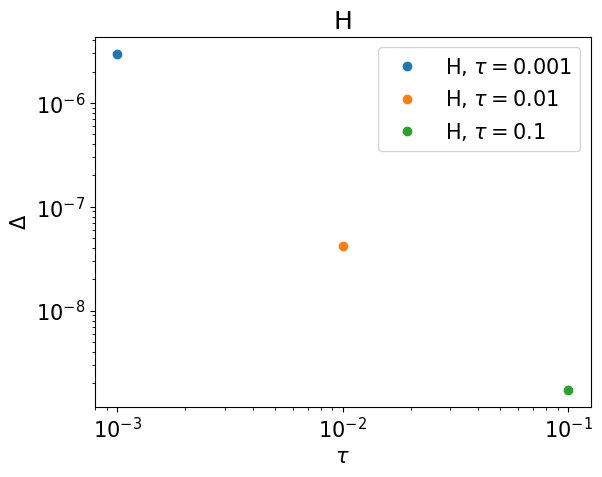

In [20]:
plt.title("H")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel("$\Delta$")
tau_list = [f["tau"] for f in frame_dict_list]
for tau,f in zip(tau_list,frame_dict_list):
    plt.plot(tau,f["inv_change"][0],"o",label=r"H, $\tau=$"+str(tau))
    print(f["inv_change"][0])
    #plt.plot(tau,f["inv_change"][1],"*",label=r"I1, $\tau=$"+str(tau))
    #plt.plot(tau,f["inv_change"][2],"^",label=r"I2, $\tau=$"+str(tau))
plt.legend(loc="best")

8.453409914752213e-09
2.8848617846738414e-10
4.781487034268324e-10


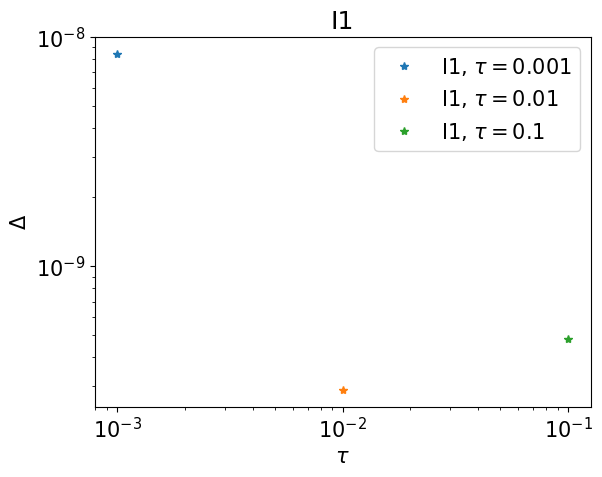

In [21]:
plt.title("I1")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel("$\Delta$")
tau_list = [f["tau"] for f in frame_dict_list]
for tau,f in zip(tau_list,frame_dict_list):
    
    plt.plot(tau,f["inv_change"][1],"*",label=r"I1, $\tau=$"+str(tau))
    print(f["inv_change"][1])
    
plt.legend(loc="best")

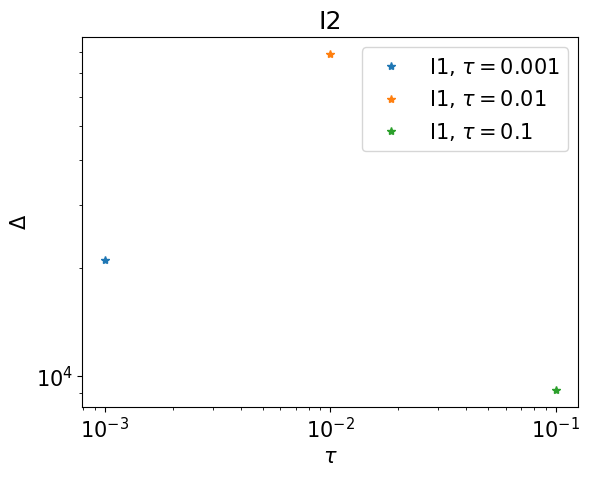

In [22]:
plt.title("I2")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel("$\Delta$")
sym = []
tau_list = [f["tau"] for f in frame_dict_list]
for tau,f in zip(tau_list,frame_dict_list):
    
    plt.plot(tau,f["inv_change"][2],"*",label=r"I1, $\tau=$"+str(tau))
    
plt.legend(loc="best")

0.6228521845946118 0.003755690859025385
2.6543794554165654 0.09688248260123757
2.6270027929357544 0.09140776628719778


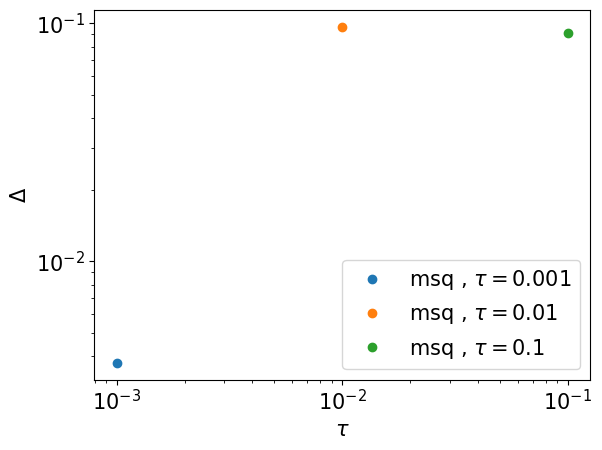

In [29]:
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel("$\Delta$")
tau_list = [f["tau"] for f in frame_dict_list]
for tau,f in zip(tau_list,frame_dict_list):
    
    abs_max_err = f["errors"][0]
    max_err = 0.5*(f["errors"][1]+f["errors"][3])
    msq_err = 0.5*(f["errors"][2]+f["errors"][4])
    print(abs_max_err,msq_err)
    #plt.plot(tau,abs_max_err,"*",label=r"abs max, $\tau=$"+str(tau))
    plt.plot(tau,msq_err,"o",label=r"msq , $\tau=$"+str(tau))
    #plt.plot(tau,f["errors"][1],"*",label=r"sqr, $\tau=$"+str(tau))
    
plt.legend(loc="lower right")

In [30]:
def plot_tau_compare(f_list,x,xi,exct_fnc,plot_type="real",plot_type2="none",kppa=kppa):
    tau_list = [f["tau"] for f in f_list]
    print("Tau list",tau_list)
    clist = ["r-","g--","b.--"]
    lablist= [r"$\tau =$" for i in range(len(tau_list)) ]
    lablist= [lablist[i]+str(tau_list[i]) for i in range(len(tau_list))]

    frame_list = [t["frame_list"] for t in f_list]
    tt = f_list[0]["t_list"]
   
    frames_sol = [exct_fnc(t*np.ones_like(x),x,kppa) for t in tt]
    if plot_type=="real":
        frame_list = [np.real(f) for f in frame_list]
        #frames = np.real(frames)
        frames_sol=np.real(frames_sol)
    elif plot_type=="imag":
        frame_list = [np.imag(f) for f in frame_list]
        #frames=np.imag(frames)
        frames_sol = np.imag(frames_sol)
    else:
        frame_list = [np.square(np.abs(f)) for f in frame_list]
        #frames=np.square(np.abs(frames))
        frames_sol = np.square(np.abs(frames_sol))
    fig = plt.figure(figsize=(12,8))
    axes = fig.add_subplot(211)
    axes2 = fig.add_subplot(212)
    line_list  = [ axes.plot(x,frames_sol[0][:],"-*",lw=3,label="sol")[0]]
    line_list2 = []
    for j,f in enumerate(frame_list):
        line_list.append(axes.plot(x,f[0][:,0],clist[j],lw=3,label=lablist[j])[0])
        line_list2.append(axes2.plot(x,f[0][:,1],clist[j],lw=3,label=lablist[j])[0])
    
    
    

    
    
    #axes2.semilogy([xi_max/2.,xi_max/2.],[1.e-6,4e8],'--r')
    #axes2.semilogy([-xi_max/2.,-xi_max/2.],[1.e-8,4e10],'--r')
    
    axes.set_ylabel(r'$q0$',fontsize=30)
    axes2.set_ylabel(r'$q1$',fontsize=30)
    plt.tight_layout()
    axes.legend(loc="best")
    axes2.legend(loc="best")
    plt.close()

    def plot_frame(i):
       
        line_list[0].set_data(x,frames_sol[i][:])
        #power_spectrum = np.abs(uuhat[i])**2
        for j,f in zip(range(len(frame_list)),frame_list):
            line_list[j+1].set_data(x,f[i][:,0])
            line_list2[j].set_data(x,f[i][:,1])

        
        
        
        axes.set_title('t= %.2e' % tt[i])
        axes.set_xlim((-8.0,8.0))
        axes.set_ylim((-0.0,8.0))
        axes2.set_xlim((-8.0,8.0))
        axes2.set_ylim((-0.0,20.0))

    anim = matplotlib.animation.FuncAnimation(fig, plot_frame,
                                              frames=len(frame_list[0]), interval=100,
                                              repeat=False)
    return HTML(anim.to_jshtml())

In [31]:
plot_tau_compare(frame_dict_list,  x, xi,exct_fnc=exact_soln_np,plot_type="abs")

Tau list [0.001, 0.01, 0.1]


In [ ]:
#########################            OLD JUNK Code: not being used    #########################

In [52]:

def plot_solution(frames, x, tt, xi,exct_fnc,plot_type="real",plot_type2="none"):
   
    frames_sol = [exct_fnc(t*np.ones_like(x),x) for t in tt]
    if plot_type=="real":
        frames = np.real(frames)
        frames_sol=np.real(frames_sol)
    elif plot_type=="imag":
        frames=np.imag(frames)
        frames_sol = np.imag(frames_sol)
    else:
        frames=np.square(np.abs(frames))
        frames_sol = np.square(np.abs(frames_sol))
    fig = plt.figure(figsize=(12,8))
    axes = fig.add_subplot(211)
    axes2 = fig.add_subplot(212)
    if plot_type2=="diff":
        line, = axes.plot(x,frames[0][:,0]-frames_sol[0][:],lw=3)
    else:
        line, = axes.plot(x,frames[0][:,0],lw=3,label="bdhdhj")
        linesol,= axes.plot(x,frames_sol[0][:],"--",lw=3)
    line2, = axes2.plot(x,frames[0][:,1],lw=3)

    
    
    #axes2.semilogy([xi_max/2.,xi_max/2.],[1.e-6,4e8],'--r')
    #axes2.semilogy([-xi_max/2.,-xi_max/2.],[1.e-8,4e10],'--r')
    if plot_type2=="diff":
        axes.set_ylabel(r'$q0-u$',fontsize=30)
    else:
        axes.set_ylabel(r'$q0$',fontsize=30)
    axes2.set_ylabel(r'$q1$',fontsize=30)
    plt.tight_layout()
    axes.legend(loc="best")
    plt.close()

    def plot_frame(i):
        if plot_type2=="diff":
            line.set_data(x,frames[i][:,0]-frames_sol[i][:])
        #
        #power_spectrum = np.abs(uuhat[i])**2
        else:
            line.set_data(x,frames[i][:,0])
            linesol.set_data(x,frames_sol[i][:])
        line2.set_data(x,frames[i][:,1])
        axes.set_title('t= %.2e' % tt[i])
        axes.set_xlim((-20.0,20.0))
        axes.set_ylim((-1.0,1.0))
        axes2.set_xlim((-20.0,20.0))
        axes2.set_ylim((-1,10))

    anim = matplotlib.animation.FuncAnimation(fig, plot_frame,
                                              frames=len(frames), interval=100,
                                              repeat=False)
    return HTML(anim.to_jshtml())

In [ ]:
plot_solution(f_tau_0p001,  x, tt_tau_0p01, xi,exct_fnc=exact_soln_np,plot_type="ss")

In [ ]:
mrk = ("b--","r-.","-*","m--")
for i in range(len(f)):
    ax = plt.subplot()
    j=i%4
    ax.plot(f[i][:,1],mrk[j],label=str(i))

In [ ]:
i=0
amp0 = np.square(np.abs(f[i][:,0]))
amp1 = np.square(np.abs(f[i][:,1]))
plt.plot(x,amp1)